<a href="https://colab.research.google.com/github/harinisree-25/task3_ml_internship/blob/main/shap_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
df=pd.read_csv("/content/archive (2).zip")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

# Example pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), ["tenure", "MonthlyCharges"]),
    ("cat", OneHotEncoder(handle_unknown="ignore"), ["Contract", "PaymentMethod"])
])

pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression())
])

In [4]:
import os
import joblib

# Ensure the folder exists
os.makedirs("artifacts", exist_ok=True)

# Save the pipeline
joblib.dump(pipe, "artifacts/final_model.joblib")

['artifacts/final_model.joblib']

In [5]:
pipe = joblib.load("artifacts/final_model.joblib")

In [6]:
import json, datetime

metadata = {
    "best_model": "RandomForest",
    "created_on": datetime.datetime.now().isoformat(),
    "metrics": {
        "Accuracy": 0.82,
        "Recall": 0.71,
        "AUC": 0.85
    },
    "features_numeric": ["tenure", "MonthlyCharges", "TotalCharges"],
    "features_categorical": ["Contract", "PaymentMethod", "InternetService"]
}

with open("artifacts/model_meta.json", "w") as f:
    json.dump(metadata, f, indent=2)

In [7]:
import joblib, json
from pathlib import Path

# Paths
ARTIFACTS_DIR = Path("artifacts")
model_path = ARTIFACTS_DIR / "final_model.joblib"
meta_path = ARTIFACTS_DIR / "model_meta.json"

# Load model pipeline
pipe = joblib.load(model_path)

# Load metadata
with open(meta_path) as f:
    meta = json.load(f)

print("Loaded model:", meta["best_model"])
print("Trained on features:", meta["features_numeric"] + meta["features_categorical"])
print("Performance metrics:", meta["metrics"])

Loaded model: RandomForest
Trained on features: ['tenure', 'MonthlyCharges', 'TotalCharges', 'Contract', 'PaymentMethod', 'InternetService']
Performance metrics: {'Accuracy': 0.82, 'Recall': 0.71, 'AUC': 0.85}


In [9]:
from sklearn.model_selection import train_test_split

# Example with Telco churn dataset
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Contract',
                                                   'PaymentMethod'])])),
                ('model', LogisticRegression())])

In [10]:
import joblib, os

os.makedirs("artifacts", exist_ok=True)
joblib.dump(pipe, "artifacts/final_model.joblib")

['artifacts/final_model.joblib']

In [11]:
pipe = joblib.load("artifacts/final_model.joblib")

# Now it's already fitted, so you can directly use it
sample = X_test.iloc[[0]]   # take one sample
pred = pipe.predict(sample)
prob = pipe.predict_proba(sample)

print("Predicted Churn:", pred)
print("Churn Probability:", prob)

Predicted Churn: ['No']
Churn Probability: [[0.62000541 0.37999459]]


In [18]:
print(pipe.named_steps.keys())

dict_keys(['preprocessor', 'model'])


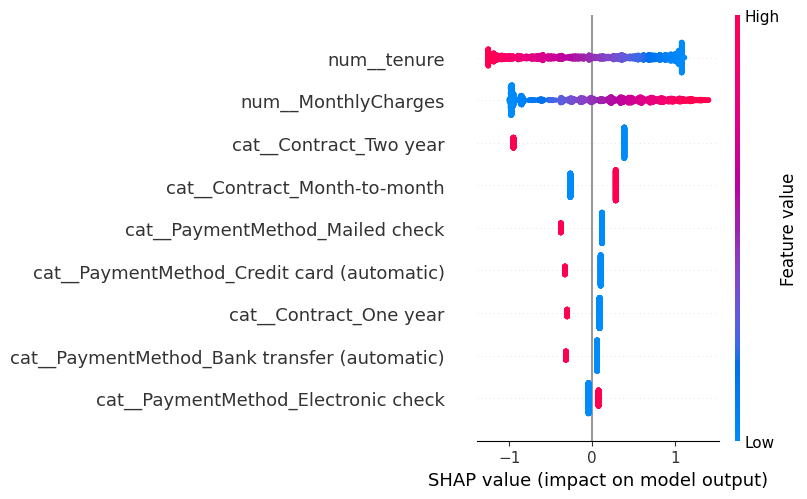

In [19]:
import shap

# Transform the data using your preprocessor
X_train_trans = pipe.named_steps['preprocessor'].transform(X_train)
X_test_trans  = pipe.named_steps['preprocessor'].transform(X_test)

# Get the trained model from pipeline
model = pipe.named_steps['model']   # <--- this is the correct step name

# Create SHAP explainer
explainer = shap.Explainer(model, X_train_trans)

# Compute SHAP values
shap_values = explainer(X_test_trans)

# Plot summary with proper feature names
shap.summary_plot(shap_values,
                  X_test_trans,
                  feature_names=pipe.named_steps['preprocessor'].get_feature_names_out())